<a href="https://colab.research.google.com/github/micah-shull/Machine_Learning_Pipelines/blob/main/pipelines_02_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Principal Component Analysis (PCA)

### What is PCA?

**Principal Component Analysis (PCA) is a dimensionality reduction technique** that transforms a large set of correlated variables into a smaller set of uncorrelated variables called principal components. The primary objective of PCA is to **reduce the dimensionality of the data while preserving as much variability as possible.**

### When to Apply PCA

1. **High-Dimensional Data**:
   - When you have a **dataset with a large number of features**, and you want to reduce the dimensionality to simplify the model and reduce computational cost.

2. **Noise Reduction**:
   - When you want to **reduce noise** in the data by focusing on the components that **capture the most variance.**

3. **Multicollinearity**:
   - When there is multicollinearity in the data, PCA can transform correlated features into uncorrelated principal components.

4. **Data Visualization**:
   - When you need to visualize high-dimensional data in a lower-dimensional space for better understanding and exploration.

5. **Feature Engineering**:
   - As a part of feature engineering to create new features that capture the most variance in the data.

#### How PCA Works

1. **Standardization**:
   - The first step in PCA is to standardize the data, ensuring each feature has a mean of 0 and a standard deviation of 1. This step is crucial because PCA is affected by the scale of the variables.

2. **Covariance Matrix Computation**:
   - Compute the covariance matrix to understand how the variables in the dataset relate to each other.

3. **Eigenvalues and Eigenvectors**:
   - Calculate the eigenvalues and eigenvectors of the covariance matrix. The eigenvectors determine the directions of the new feature space, and the eigenvalues indicate the magnitude of the variance in these directions.

4. **Principal Components**:
   - The eigenvectors form the principal components, which are ordered by the amount of variance they capture from the data. The first principal component captures the most variance, the second captures the next most, and so on.

5. **Projection**:
   - The data is projected onto the selected principal components, resulting in a reduced-dimensional representation of the original data.


### Establishing a Baseline Performance with a Simple Model

#### Purpose

1. **Benchmarking**:
   - Establishing a baseline performance **provides a point of reference to compare more complex models and advanced techniques against**. It allows you to understand the minimum performance level you can achieve with straightforward methods.

2. **Simplification**:
   - A simple model like Logistic Regression helps to quickly understand the relationship between features and the target variable. It simplifies the initial stages of model development and data exploration.

3. **Error Analysis**:
   - A baseline model can help in **identifying the strengths and weaknesses of your dataset.** By analyzing the errors and shortcomings of the baseline model, you can gain insights into the data quality and areas that need improvement.

4. **Efficiency**:
   - **Simple models are computationally efficient and faster to train.** This is especially useful in the initial stages of a project to get quick results and set expectations.




In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import seaborn as sns
import matplotlib.pyplot as plt

# Load the Adult Census Income dataset from OpenML
adult = fetch_openml(data_id=1590, as_frame=True, parser='auto')
df = adult.frame

# Rename columns to lower case and replace hyphens with underscores
df.columns = [col.lower().replace('-', '_') for col in df.columns]

# Print unique values of the target variable in the original dataset
print("Unique values in the original target variable:", df['class'].unique())

# Select features and target
target = 'class'
X = df.drop(columns=[target])
# Convert target to binary, strip any extra whitespace
y = df[target].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the pipeline with LogisticRegression
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train and evaluate the baseline model
baseline_pipeline.fit(X_train, y_train)
y_pred_baseline = baseline_pipeline.predict(X_test)
print("Baseline Logistic Regression Model Performance")
print(classification_report(y_test, y_pred_baseline))

# Perform cross-validation for the baseline model
cv_scores_baseline = cross_val_score(baseline_pipeline, X_train, y_train, cv=5)
print("Baseline Logistic Regression Cross-validation scores: ", cv_scores_baseline)
print("Baseline Logistic Regression Mean cross-validation score: ", cv_scores_baseline.mean())


Unique values in the original target variable: ['<=50K', '>50K']
Categories (2, object): ['<=50K', '>50K']
Baseline Logistic Regression Model Performance
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      7479
           1       0.74      0.61      0.67      2290

    accuracy                           0.86      9769
   macro avg       0.81      0.77      0.79      9769
weighted avg       0.85      0.86      0.85      9769

Baseline Logistic Regression Cross-validation scores:  [0.85335893 0.84977607 0.85553423 0.84847709 0.8500128 ]
Baseline Logistic Regression Mean cross-validation score:  0.851431823157772


## Implement PCA with a Baseline Logistic Regression Model

### Plot PCA Components

1. **Explained Variance Plot**:
   - This plot shows the explained variance ratio for each principal component.
   - The bar plot represents the individual explained variance, while the step plot shows the cumulative explained variance.

2. **PCA Scatter Plot**:
   - This scatter plot visualizes the data projected onto the first two principal components.
   - The color of the points corresponds to the class labels, helping to visualize the separation between classes in the reduced-dimensional space.

3. **Transforming Data**:
   - The data is transformed using PCA after preprocessing.
   - `X_train_pca` and `X_test_pca` are the transformed datasets.

4. **Training and Evaluation**:
   - The model is trained using the pipeline with PCA.
   - Predictions are made, and the performance is evaluated using a classification report and cross-validation.

By plotting the PCA components, you can visualize the variance captured by each component and how the data is distributed in the reduced-dimensional space. This helps in understanding the effectiveness of PCA in capturing the essential patterns in the data.

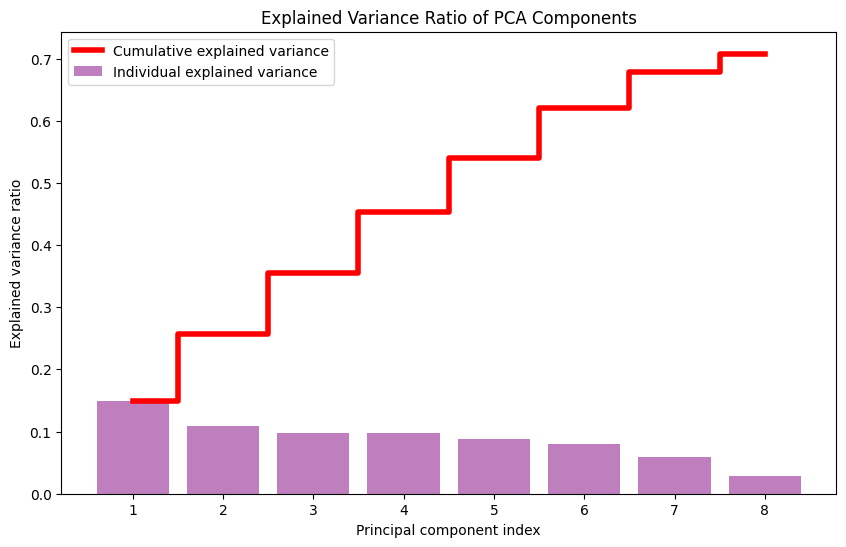

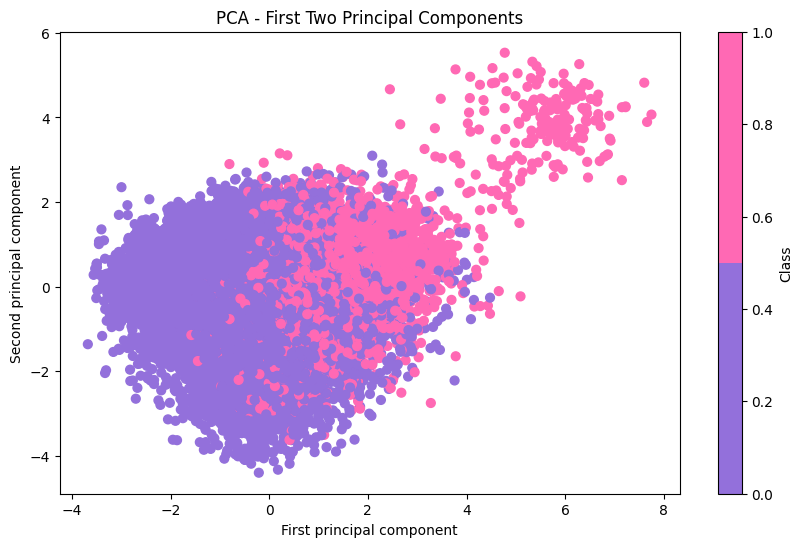

Logistic Regression with PCA Model Performance
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      7479
           1       0.72      0.57      0.64      2290

    accuracy                           0.85      9769
   macro avg       0.80      0.75      0.77      9769
weighted avg       0.84      0.85      0.84      9769

Cross-validation scores:  [0.84708893 0.83838772 0.84542546 0.83849501 0.83939084]
Mean cross-validation score:  0.8417575914483919


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml
from matplotlib.colors import ListedColormap

n = 8  # Number of PCA components to plot

# Load the Adult Census Income dataset from OpenML
adult = fetch_openml(data_id=1590, as_frame=True, parser='auto')
df = adult.frame

# Rename columns to lower case and replace hyphens with underscores
df.columns = [col.lower().replace('-', '_') for col in df.columns]

# Select features and target
target = 'class'
X = df.drop(columns=[target])
y = df[target].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the PCA transformation
pca = PCA(n_components=n)  # Adjust n_components based on the desired amount of variance to capture

# Create the pipeline with PCA and Logistic Regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the model
pipeline.fit(X_train, y_train)

# Transform the data using PCA
X_train_pca = pipeline.named_steps['pca'].transform(pipeline.named_steps['preprocessor'].transform(X_train))
X_test_pca = pipeline.named_steps['pca'].transform(pipeline.named_steps['preprocessor'].transform(X_test))

# Explained Variance Plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, n+1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance', color='purple')
plt.step(range(1, n+1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative explained variance', color='red', linewidth=4)
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.title('Explained Variance Ratio of PCA Components')
plt.legend(loc='best')
plt.show()

# Define the custom colors
colors = ['mediumpurple', 'hotpink']

# Create a ListedColormap
cmap = ListedColormap(colors)

# Scatter Plot of the First Two Principal Components
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=cmap, s=40)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('PCA - First Two Principal Components')
plt.colorbar(label='Class')
plt.show()

# Predict and evaluate the model with PCA
y_pred = pipeline.predict(X_test)
print("Logistic Regression with PCA Model Performance")
print(classification_report(y_test, y_pred))

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: ", cv_scores.mean())


### What is Explained Variance?

In the context of Principal Component Analysis (PCA), explained variance refers to the amount of variance in the original data that is captured by each principal component. PCA transforms the original features into a new set of features called principal components, which are ordered by the amount of variance they explain.

#### Explained Variance Ratio

The explained variance ratio for each principal component indicates the proportion of the total variance in the data that is accounted for by that component. The sum of the explained variance ratios of all principal components equals 1 (or 100% when expressed as a percentage).

#### Calculation

1. **Covariance Matrix**:
   - PCA starts by calculating the covariance matrix of the standardized data to understand how the variables relate to each other.

2. **Eigenvalues and Eigenvectors**:
   - Eigenvalues and eigenvectors of the covariance matrix are computed. The eigenvectors form the principal components, and the eigenvalues represent the magnitude of variance captured by each principal component.

3. **Explained Variance**:
   - The eigenvalues correspond to the amount of variance explained by each principal component.
   - The explained variance ratio for a principal component is calculated as the eigenvalue of that component divided by the sum of all eigenvalues.

#### Interpretation

1. **Individual Explained Variance Ratio**:
   - Indicates how much of the total variance is captured by each principal component.
   - For example, if the first principal component has an explained variance ratio of 0.4, it means that 40% of the total variance in the dataset is captured by this component.

2. **Cumulative Explained Variance Ratio**:
   - Shows the total variance captured by the first \( n \) principal components.
   - For instance, if the cumulative explained variance ratio of the first two components is 0.7, it means that together, these two components capture 70% of the total variance.

#### Benefits of Explained Variance Ratio

1. **Dimensionality Reduction**:
   - Helps determine the number of principal components to retain while reducing dimensionality. Typically, you choose the smallest number of components that explain a sufficiently large portion of the total variance (e.g., 95%).

2. **Feature Selection**:
   - Identifies the most important components (features) that capture the majority of the variance, allowing for more efficient and effective feature selection.

3. **Noise Reduction**:
   - By focusing on components with higher explained variance, PCA can reduce the impact of noise and irrelevant features in the data.

### Summary

- **Explained Variance Ratio**: Measures the proportion of total variance captured by each principal component.
- **Benefits**: Helps in dimensionality reduction, noise reduction, and feature selection.
- **Interpretation**: The first few principal components usually capture most of the variance, allowing you to reduce the number of features while preserving the majority of the data's variability.

Understanding the explained variance ratio is crucial for effectively applying PCA and interpreting its results in the context of dimensionality reduction and data analysis.

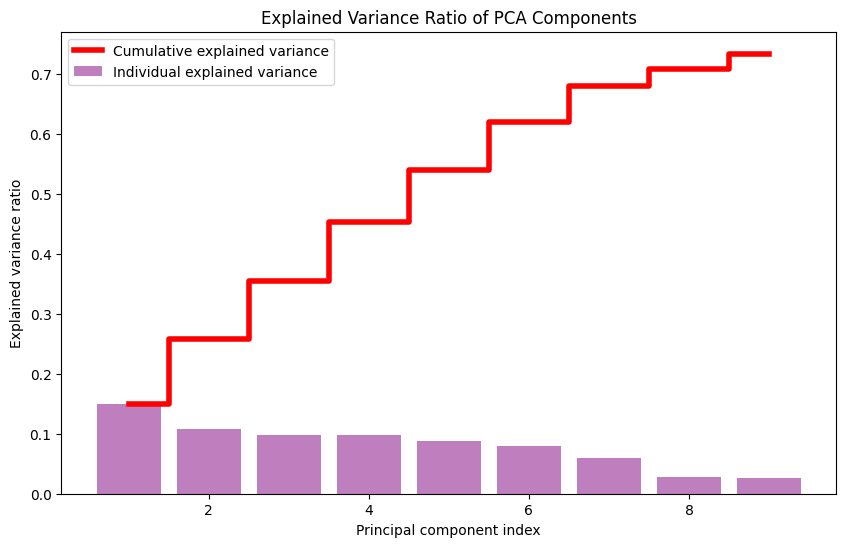

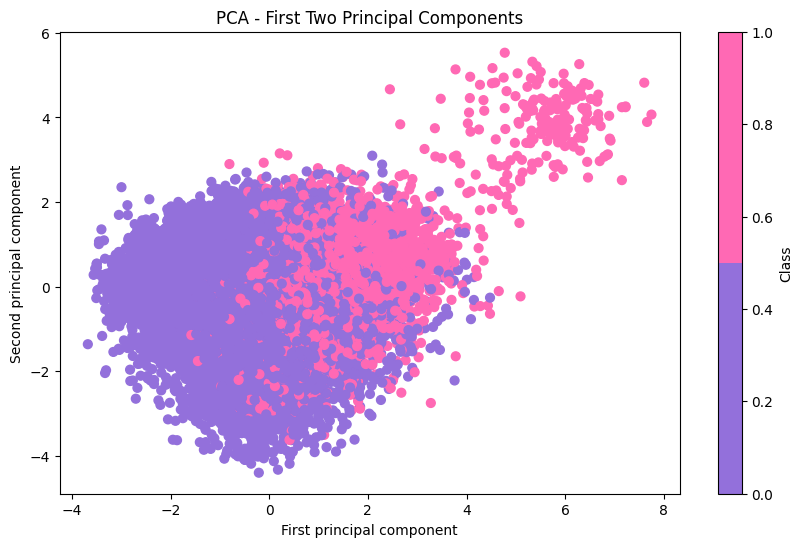

Logistic Regression with PCA Model Performance
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      7479
           1       0.72      0.57      0.64      2290

    accuracy                           0.85      9769
   macro avg       0.80      0.75      0.77      9769
weighted avg       0.84      0.85      0.84      9769

Cross-validation scores:  [0.8459373  0.83710813 0.8452975  0.83798311 0.83772716]
Mean cross-validation score:  0.8408106387783398


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml

n = 9  # Number of PCA components to plot

# Load the Adult Census Income dataset from OpenML
adult = fetch_openml(data_id=1590, as_frame=True, parser='auto')
df = adult.frame

# Rename columns to lower case and replace hyphens with underscores
df.columns = [col.lower().replace('-', '_') for col in df.columns]

# Select features and target
target = 'class'
X = df.drop(columns=[target])
y = df[target].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the PCA transformation
pca = PCA(n_components=n)  # Adjust n_components based on the desired amount of variance to capture

# Create the pipeline with PCA and Logistic Regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the model
pipeline.fit(X_train, y_train)

# Transform the data using PCA
X_train_pca = pipeline.named_steps['pca'].transform(pipeline.named_steps['preprocessor'].transform(X_train))
X_test_pca = pipeline.named_steps['pca'].transform(pipeline.named_steps['preprocessor'].transform(X_test))

# Explained Variance Plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, n+1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance', color='purple')
plt.step(range(1, n+1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative explained variance', color='red', linewidth=4)
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.title('Explained Variance Ratio of PCA Components')
plt.legend(loc='best')
plt.show()

# Scatter Plot of the First Two Principal Components
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=cmap, s=40)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('PCA - First Two Principal Components')
plt.colorbar(label='Class')
plt.show()

# Predict and evaluate the model with PCA
y_pred = pipeline.predict(X_test)
print("Logistic Regression with PCA Model Performance")
print(classification_report(y_test, y_pred))

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: ", cv_scores.mean())


## Finding the optimal number of components in PCA

Finding the optimal number of components in PCA involves balancing the trade-off between dimensionality reduction and the amount of variance explained by the components. Here are some methods to determine the optimal number of components:

1. **Explained Variance Plot (Scree Plot)**:
   - Plot the explained variance ratio for each principal component.
   - Look for the "elbow" point, where the explained variance starts to level off. This point indicates a diminishing return in terms of variance explained by additional components.

2. **Cumulative Explained Variance**:
   - Plot the cumulative explained variance ratio.
   - Choose the number of components that capture a high percentage of the total variance (commonly 95% or 99%).

3. **Cross-Validation**:
   - Perform cross-validation to evaluate the model's performance with different numbers of components.
   - Select the number of components that gives the best cross-validation score.

Here’s how to use these methods to find the optimal number of components:


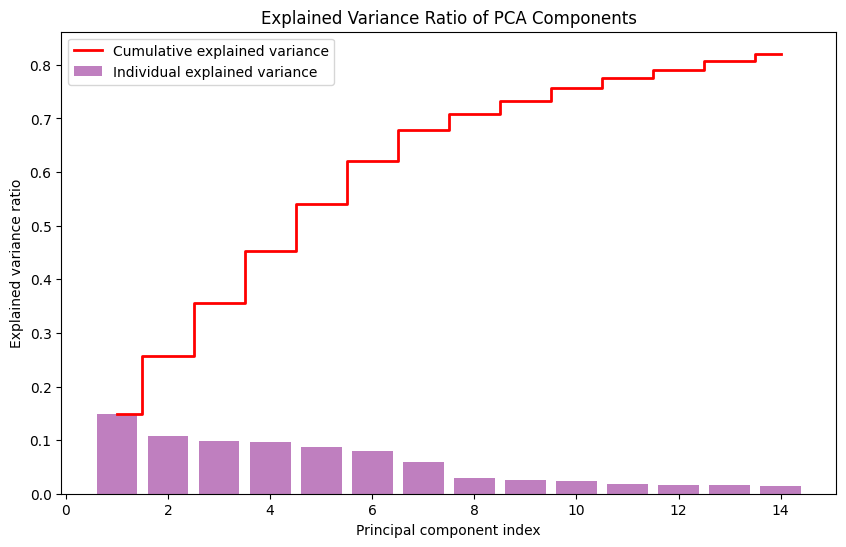

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml

# Load the Adult Census Income dataset from OpenML
adult = fetch_openml(data_id=1590, as_frame=True, parser='auto')
df = adult.frame

# Rename columns to lower case and replace hyphens with underscores
df.columns = [col.lower().replace('-', '_') for col in df.columns]

# Select features and target
target = 'class'
X = df.drop(columns=[target])
y = df[target].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply PCA with a high number of components to visualize explained variance
# Calculate the maximum allowable number of components
max_components = min(X_train.shape[0], X_train.shape[1])

# Apply PCA with the maximum allowable number of components
pca = PCA(n_components=max_components)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Get the explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Create a DataFrame to display explained variance ratios and cumulative explained variance
explained_variance_df = pd.DataFrame({
    'Principal Component': range(1, len(explained_variance_ratio) + 1),
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Explained Variance': cumulative_explained_variance
})

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance', color='purple')
plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative explained variance', color='red',linewidth=2)
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.title('Explained Variance Ratio of PCA Components')
plt.legend(loc='best')
plt.show()


#### Table of Cumulative Explained Variance

In [ ]:
# Filter the DataFrame for cumulative explained variance between 0.5 and 0.99
filtered_variance_df = explained_variance_df[(explained_variance_df['Cumulative Explained Variance'] > 0.5) &
                                             (explained_variance_df['Cumulative Explained Variance'] < 0.99)]

# Display the filtered table
print("\nFiltered Explained Variance Table (0.5 < Cumulative Explained Variance < 0.99):")
filtered_variance_df


Filtered Explained Variance Table (0.5 < Cumulative Explained Variance < 0.99):


,Principal Component,Explained Variance Ratio,Cumulative Explained Variance
4,5,0.087705,0.540230
5,6,0.080151,0.620381
6,7,0.058736,0.679117
7,8,0.028641,0.707757
8,9,0.025720,0.733478
9,10,0.023230,0.756708
10,11,0.018345,0.775052
11,12,0.016080,0.791132
12,13,0.015874,0.807007
13,14,0.013798,0.820805


### Scree Plot

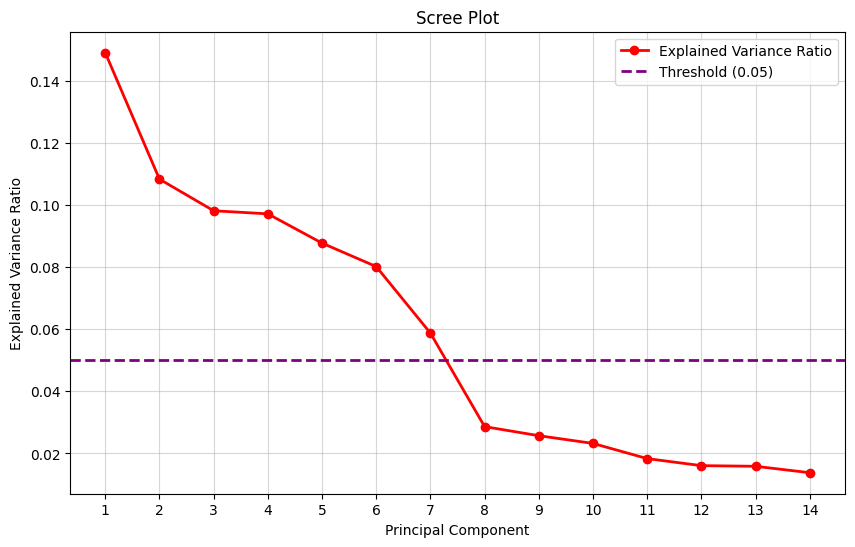

In [26]:
# Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(explained_variance_df['Principal Component'],
         explained_variance_df['Explained Variance Ratio'],
         marker='o', linestyle='-', color='red', lw=2,label='Explained Variance Ratio')

plt.axhline(y=0.05, color='purple', linestyle='--', lw=2,label='Threshold (0.05)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.xticks(range(1, len(explained_variance_df['Principal Component']) + 1))
plt.legend()
plt.grid(alpha=0.5)
plt.show()


### Select N Number of Components

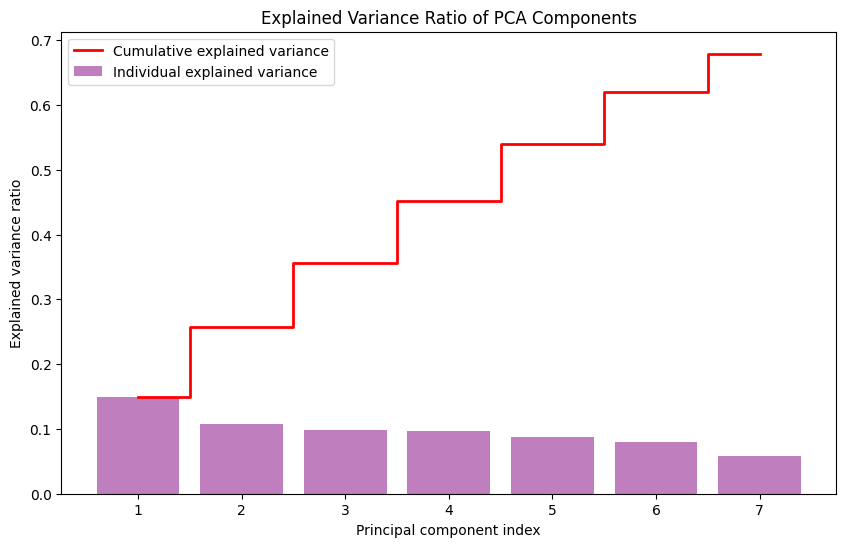

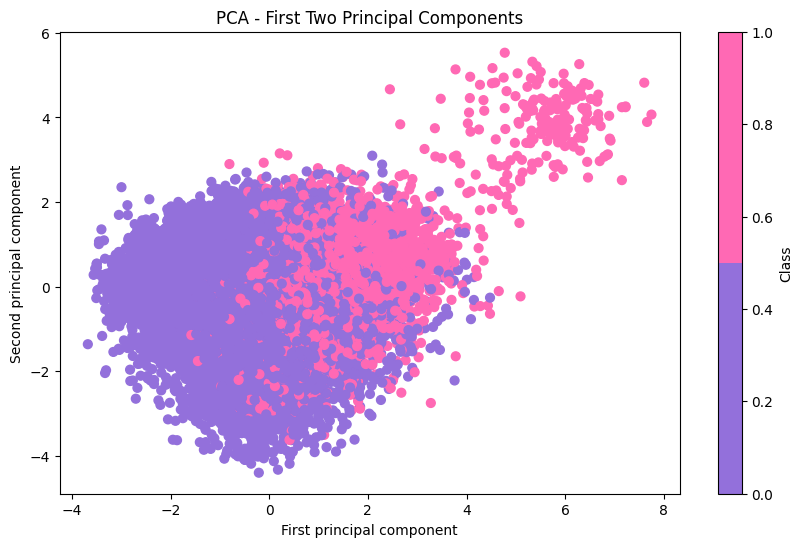

Logistic Regression with PCA Model Performance
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      7479
           1       0.72      0.55      0.62      2290

    accuracy                           0.84      9769
   macro avg       0.79      0.74      0.76      9769
weighted avg       0.83      0.84      0.84      9769

Cross-validation scores:  [0.84145873 0.83352527 0.84325016 0.8354236  0.8354236 ]
Mean cross-validation score:  0.8378162724810579


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml

n = 7  # Number of PCA components to plot

# Load the Adult Census Income dataset from OpenML
adult = fetch_openml(data_id=1590, as_frame=True, parser='auto')
df = adult.frame

# Rename columns to lower case and replace hyphens with underscores
df.columns = [col.lower().replace('-', '_') for col in df.columns]

# Select features and target
target = 'class'
X = df.drop(columns=[target])
y = df[target].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the PCA transformation
pca = PCA(n_components=n)  # Adjust n_components based on the desired amount of variance to capture

# Create the pipeline with PCA and Logistic Regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the model
pipeline.fit(X_train, y_train)

# Transform the data using PCA
X_train_pca = pipeline.named_steps['pca'].transform(pipeline.named_steps['preprocessor'].transform(X_train))
X_test_pca = pipeline.named_steps['pca'].transform(pipeline.named_steps['preprocessor'].transform(X_test))

# Explained Variance Plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, n+1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance', color='purple')
plt.step(range(1, n+1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative explained variance', color='red',linewidth=2)
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.title('Explained Variance Ratio of PCA Components')
plt.legend(loc='best')
plt.show()

# Scatter Plot of the First Two Principal Components
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=cmap, s=40)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('PCA - First Two Principal Components')
plt.colorbar(label='Class')
plt.show()

# Predict and evaluate the model with PCA
y_pred = pipeline.predict(X_test)
print("Logistic Regression with PCA Model Performance")
print(classification_report(y_test, y_pred))

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: ", cv_scores.mean())


### Cross-Validation to Find Optimal Number of Components

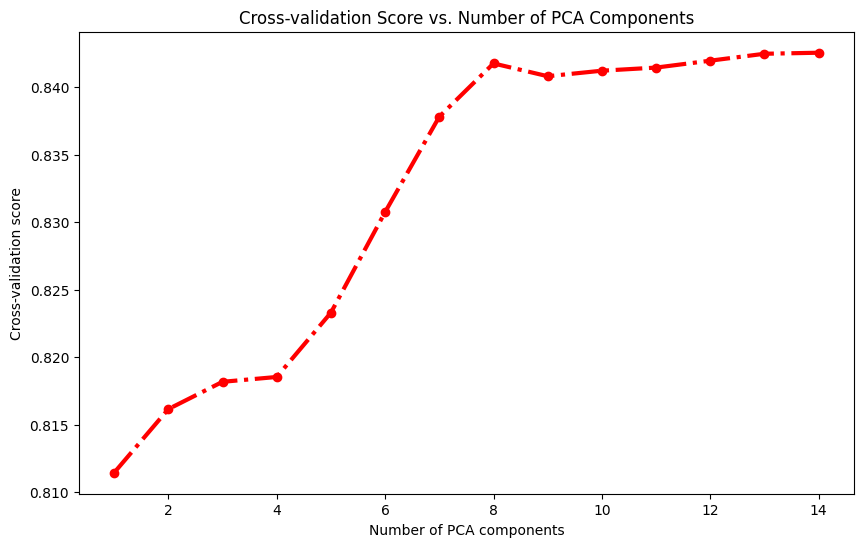

Optimal number of components based on cross-validation: 14


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml

# Load the Adult Census Income dataset from OpenML
adult = fetch_openml(data_id=1590, as_frame=True, parser='auto')
df = adult.frame

# Rename columns to lower case and replace hyphens with underscores
df.columns = [col.lower().replace('-', '_') for col in df.columns]

# Select features and target
target = 'class'
X = df.drop(columns=[target])
y = df[target].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Fit the pipeline to get the PCA explained variance
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=None)),
    ('classifier', LogisticRegression(max_iter=1000))
])
pipeline.fit(X_train, y_train)
explained_variance_ratio = pipeline.named_steps['pca'].explained_variance_ratio_

# Function to perform cross-validation for different numbers of PCA components
def evaluate_pca_components(n_components, X_train, y_train):
    pca = PCA(n_components=n_components)
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('pca', pca),
        ('classifier', LogisticRegression(max_iter=1000))
    ])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    return cv_scores.mean()

# Calculate the maximum allowable number of components
max_components = min(X_train.shape[0], X_train.shape[1])

# Evaluate model performance with different numbers of PCA components
component_range = range(1, max_components + 1)
cv_scores = [evaluate_pca_components(n, X_train, y_train) for n in component_range]

# Plot cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(component_range, cv_scores, marker='o', color='red',linestyle='-.',linewidth=3)
plt.xlabel('Number of PCA components')
plt.ylabel('Cross-validation score')
plt.title('Cross-validation Score vs. Number of PCA Components')
plt.show()

# Find the optimal number of components
optimal_n_components = component_range[np.argmax(cv_scores)]
print(f'Optimal number of components based on cross-validation: {optimal_n_components}')


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml

n = 14  # Number of PCA components to plot

# Load the Adult Census Income dataset from OpenML
adult = fetch_openml(data_id=1590, as_frame=True, parser='auto')
df = adult.frame

# Rename columns to lower case and replace hyphens with underscores
df.columns = [col.lower().replace('-', '_') for col in df.columns]

# Select features and target
target = 'class'
X = df.drop(columns=[target])
y = df[target].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the PCA transformation
pca = PCA(n_components=n)  # Adjust n_components based on the desired amount of variance to capture

# Create the pipeline with PCA and Logistic Regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the model
pipeline.fit(X_train, y_train)

# Transform the data using PCA
X_train_pca = pipeline.named_steps['pca'].transform(pipeline.named_steps['preprocessor'].transform(X_train))
X_test_pca = pipeline.named_steps['pca'].transform(pipeline.named_steps['preprocessor'].transform(X_test))

# Predict and evaluate the model with PCA
y_pred = pipeline.predict(X_test)
print("Logistic Regression with PCA Model Performance")
print(classification_report(y_test, y_pred))

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation score: ", cv_scores.mean())


Logistic Regression with PCA Model Performance
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      7479
           1       0.72      0.58      0.64      2290

    accuracy                           0.85      9769
   macro avg       0.80      0.75      0.77      9769
weighted avg       0.84      0.85      0.84      9769

Cross-validation scores:  [0.8459373  0.83902751 0.84760077 0.83785513 0.84233427]
Mean cross-validation score:  0.8425509965298434
